# Paper Plot R2, Profile, Cross-section

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from neural_networks.model_diagnostics import ModelDiagnostics
from utils.utils import read_ancilaries, find_closest_value, find_closest_longitude  # , get_pressure
from pathlib import Path
from utils.variable import Variable_Lev_Metadata
from neural_networks.cbrain.cam_constants import *
import matplotlib.pyplot as plt
import gc
import pickle
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cmocean
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

2024-04-06 08:35:27.936320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [43]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

# training_92_mask_net_prediction_thresholds_spars1e-4
# training_93_mask_net_prediction_thresholds_spars1e-5

training_run = "training_91_mask_net_prediction_thresholds_spars0.001"
base_dir = os.path.join(PROJECT_ROOT, "output_castle", training_run )
plots_dir = os.path.join(base_dir, "plots_offline_evaluation")
outputs_list_file = os.path.join(base_dir, "outputs_list.txt")

if "prediction_thresholds" in base_dir:
    train_val = "_train"
else: 
    train_val = ""

cfg = os.path.join(base_dir, "cfg_mask_net.yml")

output_dir = os.path.join(base_dir, "plots_offline_evaluation", "plots_paper" + train_val)
Path(output_dir).mkdir(parents=True, exist_ok=True)

ANCIL_FILE = os.path.join(Path.cwd().parent.resolve(), "data", "ancil_spcam.nc")

In [79]:
variable = "tphystnd" # tphystnd, phq 
stats = "r2"

In [80]:
profile_dir = os.path.join(plots_dir, "plots_profiles" + train_val, f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")

In [81]:
def load_pickle(f_name):
    with open(f_name, "rb") as f:
        values = pickle.load(f)
    return values

In [82]:
profiles = dict()

profiles["truth"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_truth.p"))
profiles["pred"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_pred.p"))
profiles[stats] = load_pickle(os.path.join(profile_dir, f"{variable}_stats-{stats}.p"))

In [83]:
def parse_txt_to_list(txt_file):
    line_list = list()
    with open(txt_file, 'r') as f:
        for line in f:
            line_list.append(line.rstrip())
    return line_list

In [84]:
outputs_list = parse_txt_to_list(outputs_list_file)

In [85]:

def plot_profile_r2(ax1): 
    blue = '#3b4cc0' #"#1E88E5"
    red = '#b40426' #"#D81B60"

    units = {"tphystnd": "K/s", "phq": "kg/(kg*s)"}

    vmin = np.min([np.min(profiles["pred"]), np.min(profiles["truth"])])
    vmax = np.max([np.max(profiles["pred"]), np.max(profiles["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    # Plotting on the primary X-axis (bottom)
    line_truth, = ax1.plot(np.mean(profiles["truth"], axis=0), P, label="SPCAM", color=blue)
    line_pred, = ax1.plot(np.mean(profiles["pred"], axis=0), P, label="Prediction", linestyle="dashed", color=blue)
    
    ax1.set_xlim(vmin, vmax)
    
    ax1.set_xlabel(f'{variable} ({units[variable]})', color=blue)
    ax1.tick_params(axis='x', colors=blue) 
    
    ax1.set_ylabel('Pressure (hPa)')
    
    # Invert the Y-axis
    ax1.invert_yaxis()
    
    # Set the Y-axis labels
    # ax1.set_yticks([1000, 600, 300, 0])
    
    # Create a secondary X-axis (top)
    ax2 = ax1.twiny()  # Share the same Y-axis

    arr = np.mean(profiles[stats], axis=1)

    if variable == "phq": 
        last_neg_index = np.where(arr< 0)[0][-1]
        # last_neg_index -= 1
    
        print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
        print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

        line_r2, = ax2.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label="R2", color=red)  
    else:     
        line_r2, = ax2.plot(arr, P, label="R2", color=red)  
    
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel('R2 score', color=red)
    ax2.tick_params(axis='x', colors=red)  # Set color of ticks and labels to red
    
    ax2.spines['top'].set_color(red)  
    ax2.spines['bottom'].set_color(blue)
    
    # ax1.set_ylabel('Pressure (hPa)', labelpad=15, color='#333333')
    # ax1.set_xlabel(f"{s}", labelpad=15, color='#333333')
    ax1.set_rasterized(True)
    ax2.set_rasterized(True)
    
    plt.legend(handles=[line_truth, line_pred, line_r2], prop={'size': 11}, loc="lower left")



Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/tphystnd_profile_r2.pdf


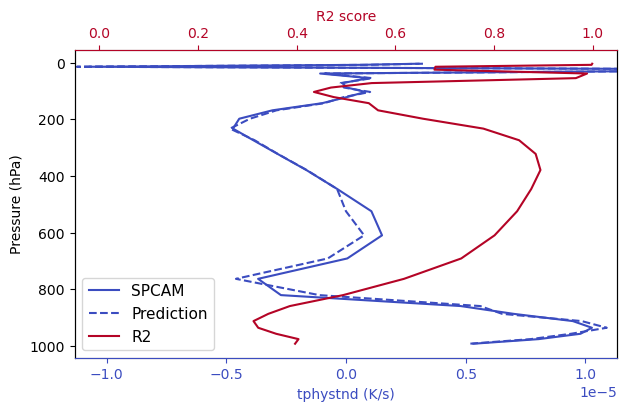

In [86]:
plt.close()

fig, ax1 = plt.subplots(figsize=(7, 4))
plot_profile_r2(ax1)

# f_path = os.path.join(output_dir, f"{variable}_profile_r2_cutoff_168.pdf")
f_path = os.path.join(output_dir, f"{variable}_profile_r2.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

plt.show()

In [66]:
cross_section_dir = os.path.join(plots_dir, "plots_cross_section" + train_val, f"mean-all_stats-{stats}_no_diff")

In [67]:
cross_sections = dict()

cross_sections["truth"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_truth.p"))
cross_sections["pred"] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_pred.p"))
cross_sections[stats] = load_pickle(os.path.join(cross_section_dir, f"{variable}_cross_section_stats-{stats}.p"))

In [68]:
v_name = variable

In [69]:

def plot_cross_section(ax, truth_or_pred, v_name):
    
    vmin = np.min([np.min(cross_sections["pred"]), np.min(cross_sections["truth"])])
    vmax = np.max([np.max(cross_sections["pred"]), np.max(cross_sections["truth"])])
    
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    extend = 'both'
    
    cThemes = {'tphystnd': 'RdBu', 'phq': 'RdBu'}
    cmap = cThemes[v_name]
    
    I = ax.imshow(cross_sections[truth_or_pred], vmin=vmin, vmax=vmax, cmap=cmap)
    
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    cb.set_label('')
    
    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))
    
    pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    ax.set_yticks(pressure_ticks)
    ax.set_yticklabels(pressure_label)
    ax.set_ylabel('Pressure (hPa)')
    
    lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    ax.set_xticks(lat_ticks)
    ax.set_xticklabels(lat_labels)
    ax.set_xlabel('Latitude')

    ax.set_rasterized(True)





Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_pred.pdf


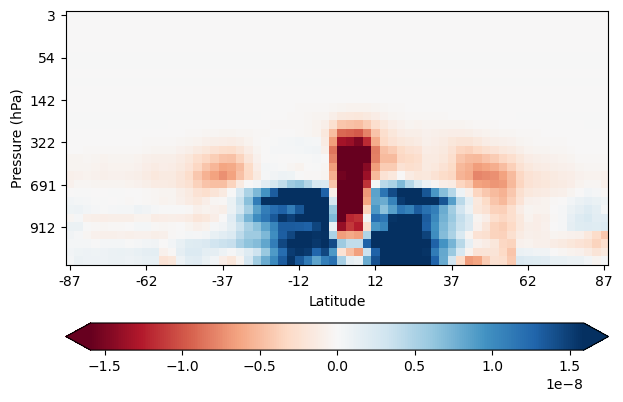

In [37]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 5))

plot_cross_section(ax, "pred", variable)

f_path = os.path.join(output_dir, f"{variable}_cross_section_pred.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

plt.show()

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_truth.pdf


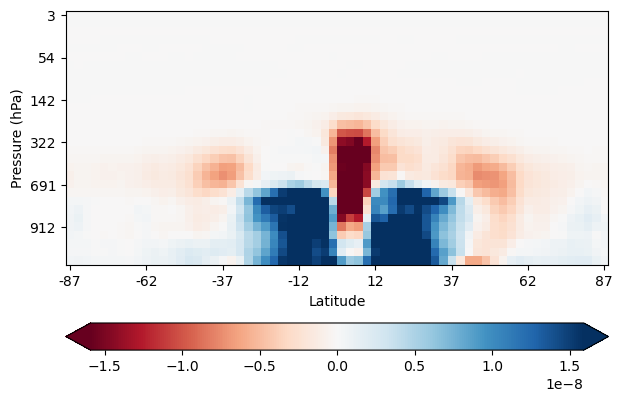

In [38]:
# Create a figure and an axis
plt.close()
fig, ax = plt.subplots(figsize=(7, 5))

plot_cross_section(ax, "truth", variable)

f_path = os.path.join(output_dir, f"{variable}_cross_section_truth.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

plt.show()

In [39]:

def plot_cross_section_r2(ax):
    vmin = 0.;
    vmax = 1.
    extend = 'min'
    cmap = 'Reds'
    
    I = ax.imshow(cross_sections[stats], vmin=vmin, vmax=vmax, cmap=cmap)
    
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', extend=extend)
    cb.set_label('')
    
    levels, latitudes, longitudes = read_ancilaries(Path(ANCIL_FILE))
    pressure_ticks = [int(press) for press in range(len(P)) if press % 5 == 0]
    pressure_label = [str(int(press)) for i, press in enumerate(P) if i % 5 == 0]
    ax.set_yticks(pressure_ticks)
    ax.set_yticklabels(pressure_label)
    ax.set_ylabel('Pressure (hPa)')
    
    lat_ticks = [int(l) for l in range(len(latitudes)) if l % 9 == 0]
    lat_labels = [str(int(l)) for i, l in enumerate(latitudes) if i % 9 == 0]
    ax.set_xticks(lat_ticks)
    ax.set_xticklabels(lat_labels)
    ax.set_xlabel('Latitude')
    
    ax.set_rasterized(True)
   

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output_castle/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train/phq_cross_section_r2.pdf


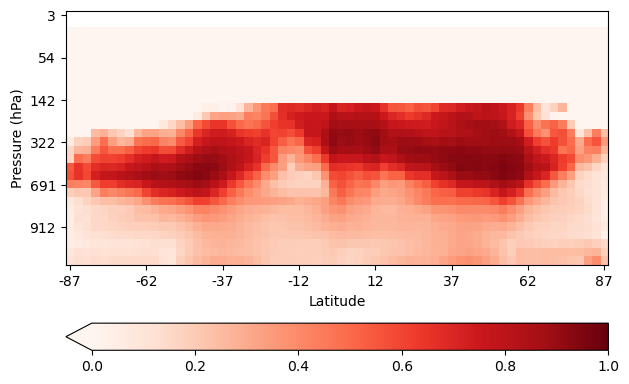

In [40]:
plt.close()
fig, ax = plt.subplots(figsize=(7, 5))
plot_cross_section_r2(ax)

f_path = os.path.join(output_dir, f"{variable}_cross_section_r2.pdf")
fig.savefig(f_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"Saved figure {f_path}")

 
plt.show()

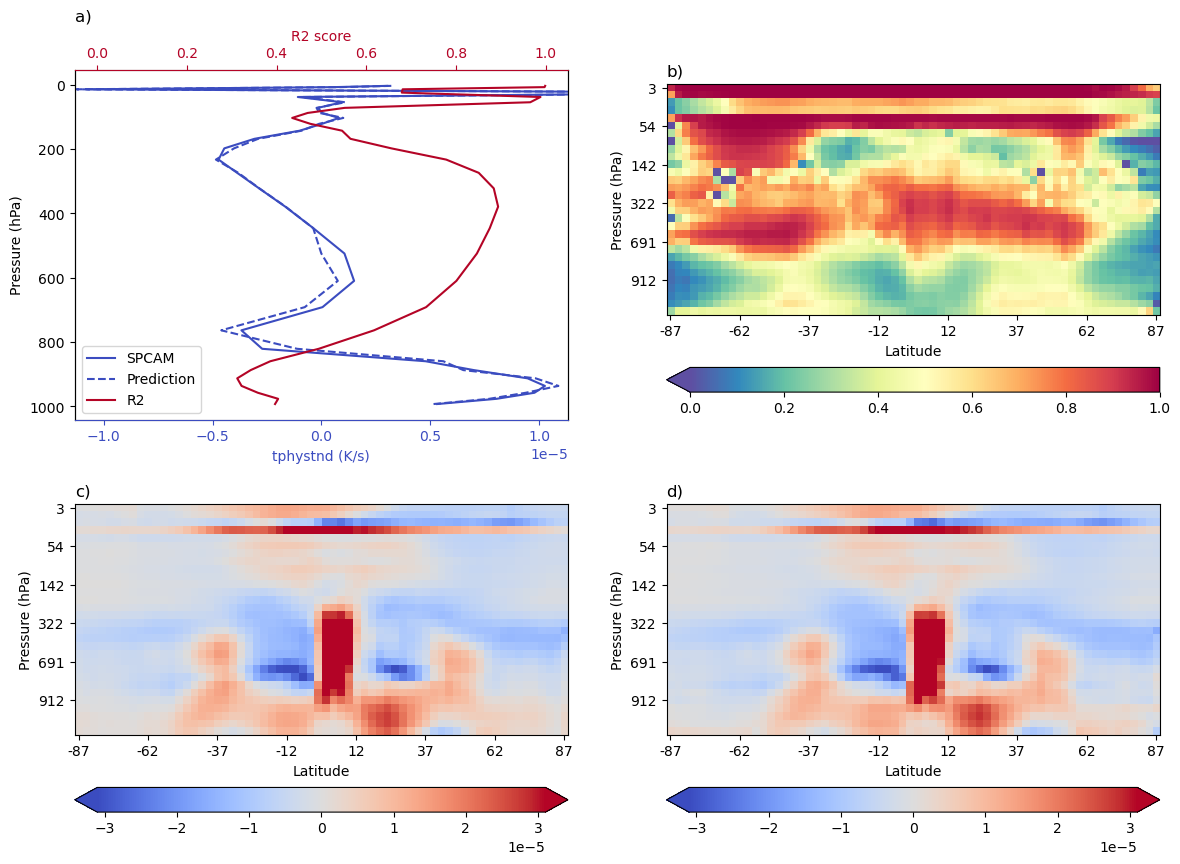

In [20]:
plt.close()

fig, axs = plt.subplots(2, 2,  figsize=(14, 10))
# fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'd)']],
#                               layout='constrained', 
#                               figsize=(14, 10))

plot_profile_r2(axs[0, 0])
axs[0, 0].set_title("a)", fontsize="large", loc="left")

plot_cross_section_r2(axs[0, 1])
axs[0, 1].set_title("b)", fontsize="large", loc="left")

plot_cross_section(axs[1, 0], "truth", variable)
axs[1, 0].set_title("c)", fontsize="large", loc="left")

plot_cross_section(axs[1, 1], "pred", variable)
axs[1, 1].set_title("d)", fontsize="large", loc="left")


plt.show()
